# Preprocessing the data

The data can be found at: https://data.seattle.gov/Public-Safety/Seattle-Real-Time-Fire-911-Calls/kzjm-xkqj
In this notebook we will load the data in and have a first look at it to get some ideas of how we approach the project. Finally, we will do all the necessary processing to start with the training and testing of the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

plt.style.use('fivethirtyeight')

In [2]:
def get_season(x):
    #takes the extracted month and converts it into season
    spring_months=[3,4,5]
    summer_months=[6,7,8]
    autumn_months=[9,10,11]
    winter_months=[12,1,2]
    
    if x in spring_months:
        out=1
    elif x in summer_months:
        out=2
    elif x in autumn_months:
        out=3
    elif x in winter_months:
        out=4
    
    return out
        

def get_features(df):
    #takes the imported data frame and adds the features
    df['dayofweek']=df.index.dayofweek
    df['dayofyear']=df.index.dayofyear
    df['month']=df.index.month
    df['weekofyear']=df.index.isocalendar().week
    df['season']=df['month']
    df['season']=df['season'].apply(get_season)
    target_map=df['counts'].to_dict()
    df['lag_year']=(df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_month']=(df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag_week']=(df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag_day']=(df.index - pd.Timedelta('1 day')).map(target_map)
    
    return df  
    

In [3]:
def load_and_preprocess(file_path, resampling_freq):
    # loads and preprocesses the raw data
    # file_path as str
    # resampling_freq as str example: '1D' for 1 Day
    
    data=pd.read_csv(file_path)
    data['Datetime'] = pd.to_datetime(data['Datetime']).dt.strftime('%m/%d/%Y %H:%M:%S')
    data['Datetime']=pd.to_datetime(data['Datetime'])
    data = data.set_index('Datetime')
    data = data.sort_index()
    data['counts']=1
    data=data.drop(['Address','Report Location','Latitude','Longitude', 'Type', 'Incident Number'],axis=1)
    data=data.resample(resampling_freq).sum()
    return data

def load_and_pre_weather(list_of_file_path,first_timepoint, last_timepoint):
    #loads and pre-process the weather data
    #
    #list_of_file_path: takes a list of strings with the file path to the weather data
    #
    #first_time_point: time stamp as str for the first timepoint of the data 
    #i.e. the first time point in the 911 data
    #last_time_point: time stamp as str for the last timepoint of the data 
    #i.e. the last time point in the 911 data
    
    df_list=[]
    for i in list_of_file_path:
        
        df=pd.read_csv(i ,skiprows=1)
        df.drop(['TAVG (Degrees Fahrenheit)', 'SNWD (Inches)', 'SNOW (Inches)'], axis=1, inplace=True)
        df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
        
        df['PRCP (Inches)']=df['PRCP (Inches)'].fillna(0)
        df['TMAX (Degrees Fahrenheit)']=df['TMAX (Degrees Fahrenheit)'].fillna(method='ffill')
        df['TMIN (Degrees Fahrenheit)']=df['TMIN (Degrees Fahrenheit)'].fillna(method='ffill')
        
    df_list.append(df)
    w_data=pd.concat([df_list[0].loc[first_timepoint:last_timepoint,:], 
                          df_list[0].loc[first_timepoint:last_timepoint,:]]).groupby(level=0).mean()
    
        
    return w_data
    
    
    

In [4]:
data = load_and_preprocess(file_path='/Users/lutz/Documents/911_data/data/Seattle_Real_Time_Fire_911_Calls.csv',
                          resampling_freq= '1D' )

By looking at the data we can see that there are 5 columns. For now the most important one is the 'Datetime' column. Therefore, we first converted the data in this columns from string to pandas datetime format and made this column the new index. Furhtermore, we added a new count column and initialized this column with '1'. In addition, we dropped the remaining columns for now. Lastly, we resampled the data frame to a appropiate frequency. We will start with one day.
Now we can plot the data to get a first impression. 

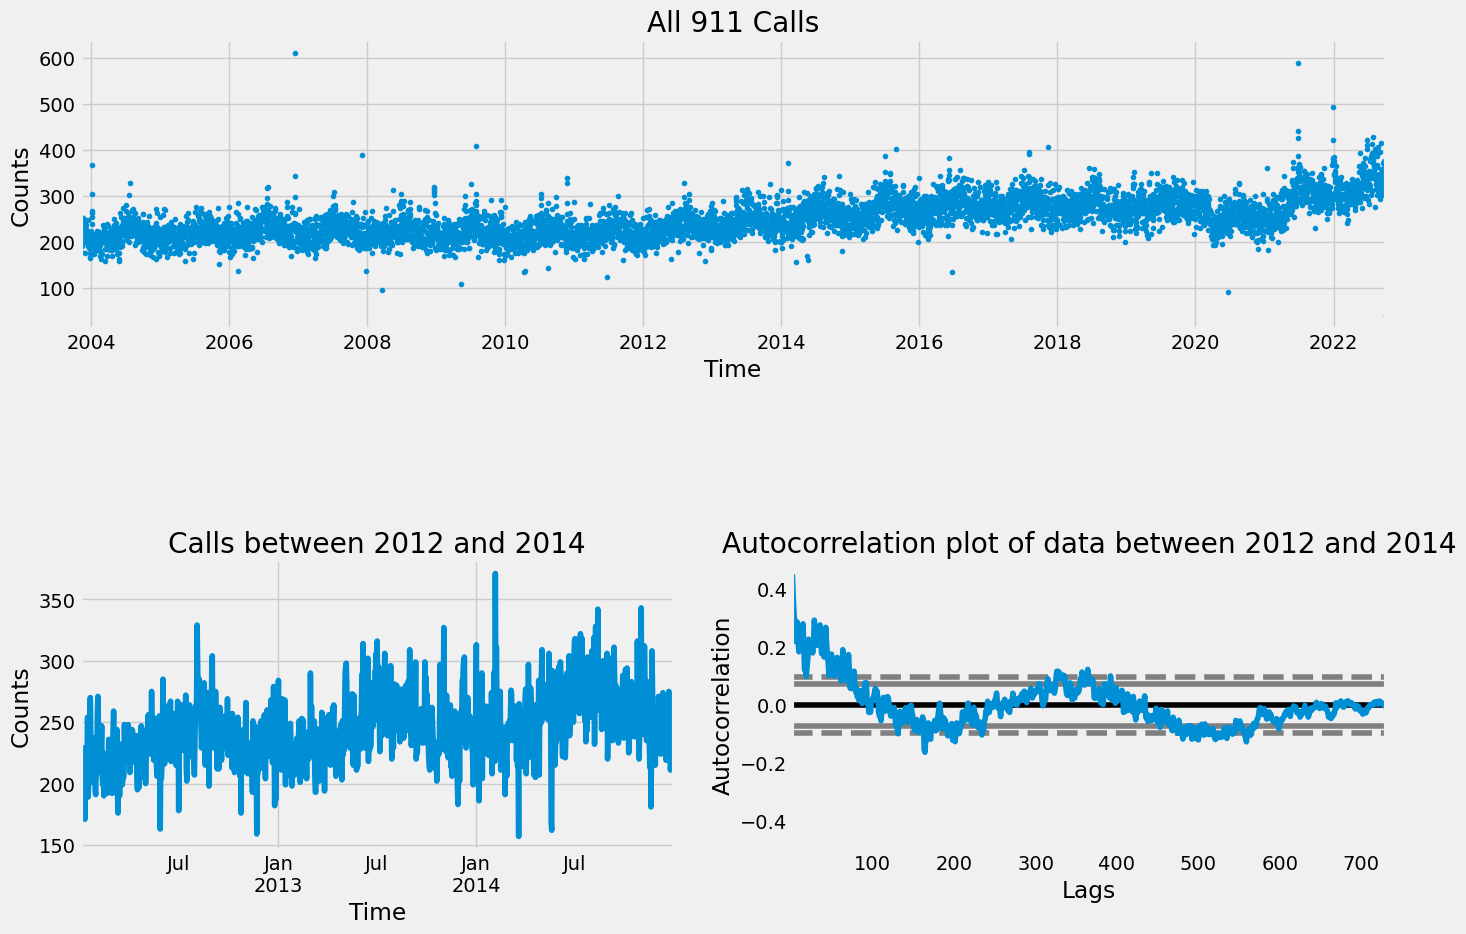

In [5]:
grid = plt.GridSpec(2, 2, wspace=0.2, hspace=0.8)


plt.subplot(grid[0, :2])
data.loc[:,'counts'].plot(style='.', figsize=(15,5))
ax_1=plt.gca()
ax_1.set_title('All 911 Calls')
ax_1.set_xlabel('Time')
ax_1.set_ylabel('Counts')

plt.subplot(grid[1, 0])
data.loc[pd.to_datetime('2012-01-01 01:00:00'):pd.to_datetime('2014-12-31 23:00:00'),'counts'].plot(style='-')
ax_2=plt.gca()
ax_2.set_title('Calls between 2012 and 2014')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('Counts')

plt.subplot(grid[1, 1])
pd.plotting.autocorrelation_plot(data.loc[pd.to_datetime('2012-01-01 01:00:00'):pd.to_datetime('2013-12-31 23:00:00'),'counts'])
ax_3=plt.gca()
ax_3.set_title('Autocorrelation plot of data between 2012 and 2014')
ax_3.set_xlabel('Lags')
ax_3.set_ylabel('Autocorrelation')
ax_3.set_ylim(-0.5,0.5)

fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()


We can already see some patterns by just looking at the data. There seems to be some seasonality within the data, with peaks during the sommer. Furthermore, two global trends are more obvious:

1. An overall increase in counts after 2014
2. A sharper increase after 2021

Now we can start with the feature engineering. We will add several more columns for different aspects of the datetime data:

1. Day of the Week
2. Day of the Year
3. Week of the Year
4. Month
5. Season
6. Lag Year (count one year ago)
7. Lag Month (count one month ago)
8. Lag Week (count one week ago)
9. Lag Day (count one day ago)

In [6]:
data=get_features(data)

data

,counts,dayofweek,dayofyear,month,weekofyear,season,lag_year,lag_month,lag_week,lag_day
Datetime,,,,,,,,,,
2003-11-07,199,4,311,11,45,3,NaN,NaN,NaN,NaN
2003-11-08,254,5,312,11,45,3,NaN,NaN,NaN,199.0
2003-11-09,240,6,313,11,45,3,NaN,NaN,NaN,254.0
2003-11-10,239,0,314,11,46,3,NaN,NaN,NaN,240.0
2003-11-11,179,1,315,11,46,3,NaN,NaN,NaN,239.0
...,...,...,...,...,...,...,...,...,...,...
2022-09-29,364,3,272,9,39,3,301.0,316.0,350.0,349.0
2022-09-30,349,4,273,9,39,3,321.0,395.0,314.0,364.0
2022-10-01,338,5,274,10,39,3,297.0,311.0,309.0,349.0


Other factors might also be important to predict the overall 911 call volume, for instance, the weather.
Therefore, we downloaded weather data from https://www.ncei.noaa.gov/access/past-weather/Seattle. There are only two weather stations that inlcude temperature and precipitation during our time frame. 

First we are doing some data cleaning:

1. Dropping columns we do not need.
2. Converting the 'Date' column into pandas datetime format and making this columns the new index
3. Sorting the data after the new index

Now we check for missing values. There are some missing values in each of the columns. We chose different methods to fill those missing values:
1. For the two temperature columns we used the ffill method.
2. For the precipitation column we filled the Missing values with zeros

Now we need to combine the data of the two weather stations. We first take the time frame of our 911 call data. After that we combine the weather data by taking the mean of the two weather stations.

In [7]:
first_timepoint='2003-11-07 09:00:00'
last_timepoint='2022-10-01 00:00:00'

w_data=load_and_pre_weather(['/Users/lutz/Documents/911_data/data/weather_data_seattle_boing_field.csv',
                                         '/Users/lutz/Documents/911_data/data/weather_data_seattle_sand_point.csv'],
                                         first_timepoint=first_timepoint,
                                         last_timepoint=last_timepoint)

In [8]:
w_data

,TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches)
Date,,,
2003-11-08,57.0,45.0,0.00
2003-11-09,52.0,41.0,0.00
2003-11-10,53.0,40.0,0.03
2003-11-11,56.0,40.0,0.00
2003-11-12,56.0,37.0,0.00
...,...,...,...
2022-09-27,79.0,52.0,0.00
2022-09-28,67.0,55.0,0.03
2022-09-29,72.0,54.0,0.00


Looks good. Now we need to combine the the weather data with the 911 call data and save this data as a csv file.

In [9]:
combined_data=data.loc[first_timepoint:last_timepoint,:].join(w_data)
combined_data

,counts,dayofweek,dayofyear,month,weekofyear,season,lag_year,lag_month,lag_week,lag_day,TMAX (Degrees Fahrenheit),TMIN (Degrees Fahrenheit),PRCP (Inches)
Datetime,,,,,,,,,,,,,
2003-11-08,254,5,312,11,45,3,NaN,NaN,NaN,199.0,57.0,45.0,0.00
2003-11-09,240,6,313,11,45,3,NaN,NaN,NaN,254.0,52.0,41.0,0.00
2003-11-10,239,0,314,11,46,3,NaN,NaN,NaN,240.0,53.0,40.0,0.03
2003-11-11,179,1,315,11,46,3,NaN,NaN,NaN,239.0,56.0,40.0,0.00
2003-11-12,215,2,316,11,46,3,NaN,NaN,NaN,179.0,56.0,37.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27,361,1,270,9,39,3,284.0,341.0,352.0,375.0,79.0,52.0,0.00
2022-09-28,349,2,271,9,39,3,275.0,341.0,351.0,361.0,67.0,55.0,0.03
2022-09-29,364,3,272,9,39,3,301.0,316.0,350.0,349.0,72.0,54.0,0.00


In [10]:
combined_data.to_csv('/Users/lutz/Documents/911_data/data/combined_data_20221010.csv')